In [0]:
from __future__ import division, print_function
from gensim import models
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from sklearn.model_selection import train_test_split
from keras.layers.advanced_activations import LeakyReLU
import numpy as np
import pandas as pd
import os
import collections
import re
import string
!pip install emoji
import emoji
from emoji import UNICODE_EMOJI
from keras.utils.np_utils import to_categorical

libraries and packages to be installed- 
Final_Emojis - emotions1.csv, 
emoji2vec.bin, 
phrase2vec.py, and 
Google's word2net package, which gets uploaded when you run the respective cell below


In [0]:
%load_ext autoreload
%autoreload 2

import math
import gensim
import gensim.models as gs
import pickle as pk
import sklearn.metrics as met
import scipy.stats as stats
import numpy as np


from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from gensim import models
import phrase2vec as p2v

In [0]:
in_dim = 300   # Length of word2vec vectors
out_dim = 300  # Desired dimension of output vectors
pos_ex = 4
neg_ratio = 1
max_epochs = 40
dropout = 0.0
e2v_ours_path = 'emoji2vec.bin'
e2v_ours = gensim.models.KeyedVectors.load_word2vec_format(e2v_ours_path, binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
!wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz

--2020-04-30 20:43:48--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.100.45
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.100.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  5.46MB/s    in 2m 20s  

2020-04-30 20:46:09 (11.2 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [0]:
word2vec_path = 'GoogleNews-vectors-negative300.bin.gz'
word2vec = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
def file_load(path):
  df = pd.read_csv(path)
  df.Tweet=df.Tweet.astype(str)
  return df
df1 = file_load("Final_Emojis - emotions1.csv")
df4 = file_load("emotions1 - emotions1.csv")
df3 = file_load("Dataset_With_Emoji.csv")

In [0]:
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test
train1, validate1, test1 = train_validate_test_split(df1)

In [0]:
train3, validate3, test3 = train_validate_test_split(df3)
train4, validate4, test4 = train_validate_test_split(df4)

In [0]:
emo = {'joy':0,'anger':1,'neutral':2,'sadness/fear':3}
train_label1 = train1['Affect Dimension']
train_tweet1 = train1['Tweet']

test_label1 = test1['Affect Dimension']
test_tweet1 = test1['Tweet']
validate_label1 = validate1['Affect Dimension']
validate_tweet1 = validate1['Tweet']
train_label1 = [emo[i] for i in train1.iloc[:, 1]]
test_label1 = [emo[i] for i in test1.iloc[:, 1]]
validate_label1 = [emo[i] for i in validate1.iloc[:, 1]]

In [0]:
emo = {'joy':0,'anger':1,'neutral':2,'sadness/fear':3}
train_label3 = train3['Affect Dimension']
train_tweet3 = train3['Tweet']
test_label3 = test3['Affect Dimension']
test_tweet3 = test3['Tweet']
validate_label3 = validate3['Affect Dimension']
validate_tweet3 = validate3['Tweet']
train_label3 = [emo[i] for i in train3.iloc[:, 2]]
test_label3 = [emo[i] for i in test3.iloc[:, 2]]
validate_label3 = [emo[i] for i in validate3.iloc[:, 2]]

In [0]:
emo = {'joy':0,'anger':1,'neutral':2,'sadness/fear':3}
train_label4 = train4['Affect Dimension']
train_tweet4 = train4['Tweet']
test_label4 = test4['Affect Dimension']
test_tweet4 = test4['Tweet']
validate_label4 = validate4['Affect Dimension']
validate_tweet4 = validate4['Tweet']
train_label4 = [emo[i] for i in train4.iloc[:, 1]]
test_label4 = [emo[i] for i in test4.iloc[:, 1]]
validate_label4 = [emo[i] for i in validate4.iloc[:, 1]]

In [0]:
import nltk
nltk.download('punkt')
from nltk import word_tokenize, WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
stoplist = stopwords.words('english')
punclist= ['!',',','@','#','"','$','%','&','*',"'", '(',")",'+','-', '.',':',';','/','=','?','_','{','}','^','[',']']



def preproc(sample):
  tff = []
  sample = [s.lower() for s in sample]
  tokens = [word_tokenize(sen) for sen in sample]
  for i in tokens:
    tokens1 = []
    final = []
    tokens1 = [word for word in i if word not in stoplist]
    final = [word for word in tokens1 if word not in punclist]
    tff.append(final)
  return tff

listnew_train1 = preproc(train_tweet1)
listnew_test1 = preproc(test_tweet1)
listnew_validate1 = preproc(validate_tweet1)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
listnew_train3 = preproc(train_tweet3)
listnew_test3 = preproc(test_tweet3)
listnew_validate3 = preproc(validate_tweet3)

In [0]:
listnew_train4 = preproc(train_tweet4)
listnew_test4 = preproc(test_tweet4)
listnew_validate4 = preproc(validate_tweet4)

In [0]:
def uniquelists(vector,listnew_train):
  uniq_list = []
  for i in listnew_train:
    for word in i:
      if word not in uniq_list:
        if word in vector:
          uniq_list.append(word)
  return uniq_list

In [0]:
uniq_W_list1 = uniquelists(word2vec,listnew_train1)
uniq_E_list1 = uniquelists(e2v_ours,listnew_train1)
for i in listnew_train1:
    for word in i:
      if word not in uniq_W_list1 and word not in uniq_E_list1:
        for w in word:
          if w in e2v_ours and w not in uniq_E_list1:
            uniq_E_list1.append(w)

In [0]:
uniq_W_list3 = uniquelists(word2vec,listnew_train3)
train_embedding_weights_W3 = np.zeros((len(uniq_W_list3)+1, 300))
for index in range(len(uniq_W_list3)):
    word = uniq_W_list3[index]
    train_embedding_weights_W3[index,:] = word2vec[word] if word in word2vec else np.random.rand(300)

In [0]:
uniq_W_list4 = uniquelists(word2vec,listnew_train4)
train_embedding_weights_W4 = np.zeros((len(uniq_W_list4)+1, 300))
for index in range(len(uniq_W_list4)):
    word = uniq_W_list4[index]
    train_embedding_weights_W4[index,:] = word2vec[word] if word in word2vec else np.random.rand(300)

In [0]:
train_embedding_weights_W1 = np.zeros((len(uniq_W_list1)+1, 300))
train_embedding_weights_E1 = np.zeros((len(uniq_E_list1)+1, 300))
for index in range(len(uniq_W_list1)):
    word = uniq_W_list1[index]
    train_embedding_weights_W1[index,:] = word2vec[word] if word in word2vec else np.random.rand(300)
for index in range(len(uniq_E_list1)):
    word = uniq_E_list1[index]
    train_embedding_weights_E1[index,:] = e2v_ours[word] if word in e2v_ours else np.random.rand(300)
print(train_embedding_weights_E1.shape)

(42, 300)


In [0]:
train_embedding_weights1 = np.vstack((train_embedding_weights_W1, train_embedding_weights_E1))
train_embedding_weights1.shape

(10384, 300)

In [0]:
def input_for_embedding1(sample,num,uniq_W_list,uniq_E_list):
  
  max_seq_len = 50
  tff = np.zeros((sample.shape[0],max_seq_len))
  sample = [s.lower() for s in sample]
  tokens = [word_tokenize(sen) for sen in sample]
  row = 0
  for i in tokens:
    column = 0
    for j in range(max_seq_len):
      if j>=len(i):
        tff[row,column] = num
        column+=1
        continue
      else:
        wordy = i[j]
        if wordy in uniq_W_list:     
          col = uniq_W_list.index(wordy)
        elif wordy in uniq_E_list:
          col = uniq_E_list.index(wordy) 
        else:
          ctr = 0
          for w in wordy:
            if w in uniq_E_list:       
              col =  uniq_E_list.index(w)
              ctr+=1
              break
          if ctr == 0:
            col = num
      tff[row,column] = col
      column +=1
    
    row +=1
  return tff

In [0]:
def input_for_embedding34(sample,num,uniq_W_list):
  
  max_seq_len = 50
  tff = np.zeros((sample.shape[0],max_seq_len))
  sample = [s.lower() for s in sample]
  tokens = [word_tokenize(sen) for sen in sample]
  row = 0
  for i in tokens:
    column = 0
    for j in range(max_seq_len):
      if j>=len(i):
        tff[row,column] = num
        column+=1
        continue
      else:
        wordy = i[j]
        if wordy in uniq_W_list:     
          col = uniq_W_list.index(wordy)
        else:
          col = num
      tff[row,column] = col
      column +=1
    
    row +=1
  return tff

In [0]:
from keras.preprocessing import sequence
train_data1 = input_for_embedding1(train_tweet1,train_embedding_weights1.shape[0] - 1,uniq_W_list1,uniq_E_list1)
test_data1 = input_for_embedding1(test_tweet1,train_embedding_weights1.shape[0] - 1,uniq_W_list1,uniq_E_list1)
validate_data1 = input_for_embedding1(validate_tweet1,train_embedding_weights1.shape[0] - 1,uniq_W_list1,uniq_E_list1)

In [0]:
from keras.preprocessing import sequence
train_data3 = input_for_embedding34(train_tweet3,train_embedding_weights_W3.shape[0] - 1,uniq_W_list3)
test_data3 = input_for_embedding34(test_tweet3,train_embedding_weights_W3.shape[0] - 1,uniq_W_list3)
validate_data3 = input_for_embedding34(validate_tweet3,train_embedding_weights_W3.shape[0] - 1,uniq_W_list3)

In [0]:
train_data4 = input_for_embedding34(train_tweet4,train_embedding_weights_W4.shape[0] - 1,uniq_W_list4)
test_data4 = input_for_embedding34(test_tweet4,train_embedding_weights_W4.shape[0] - 1,uniq_W_list4)
validate_data4 = input_for_embedding34(validate_tweet4,train_embedding_weights_W4.shape[0] - 1,uniq_W_list4)

**LSTM** (without emoticons) using **Word2Vec Embedding**

In [0]:
vocab_size=train_embedding_weights_W4.shape[0]
op_dim=300
lstm=196
output=len(emo)
modela = Sequential()
e = Embedding(vocab_size, op_dim, input_length=train_data4.shape[1], weights=[train_embedding_weights_W4], trainable=False)
modela.add(e)
modela.add(LSTM(lstm, dropout=0.2, recurrent_dropout=0.2))
modela.add(Dense(output,activation='softmax'))
modela.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(modela.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 300)           3166800   
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               389648    
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 788       
Total params: 3,557,236
Trainable params: 390,436
Non-trainable params: 3,166,800
_________________________________________________________________
None


In [0]:
historya = modela.fit(np.array(train_data4),
      to_categorical(np.array(train_label4)), epochs = 15, batch_size=128, verbose = 1, 
          validation_data=(np.array(validate_data4), to_categorical(np.array(validate_label4))))

Train on 7693 samples, validate on 2564 samples
Epoch 1/15
7693/7693 [==============================] - 25s 3ms/step - loss: 1.2563 - accuracy: 0.3898 - val_loss: 1.0842 - val_accuracy: 0.4668
Epoch 2/15
7693/7693 [==============================] - 25s 3ms/step - loss: 1.1087 - accuracy: 0.4886 - val_loss: 1.0274 - val_accuracy: 0.5542
Epoch 3/15
7693/7693 [==============================] - 25s 3ms/step - loss: 1.0455 - accuracy: 0.5339 - val_loss: 1.0705 - val_accuracy: 0.5269
Epoch 4/15
7693/7693 [==============================] - 25s 3ms/step - loss: 1.0261 - accuracy: 0.5619 - val_loss: 0.9049 - val_accuracy: 0.6244
Epoch 5/15
7693/7693 [==============================] - 25s 3ms/step - loss: 0.9278 - accuracy: 0.6194 - val_loss: 0.8802 - val_accuracy: 0.6357
Epoch 6/15
7693/7693 [==============================] - 25s 3ms/step - loss: 0.9146 - accuracy: 0.6262 - val_loss: 0.8528 - val_accuracy: 0.6615
Epoch 7/15
7693/7693 [==============================] - 25s 3ms/step - loss: 0.898

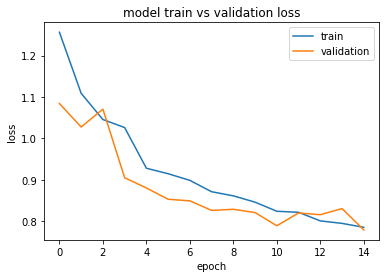

In [0]:
from matplotlib import pyplot
pyplot.plot(historya.history['loss'])
pyplot.plot(historya.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [0]:
modela.evaluate(
  np.array(test_data4),
  to_categorical(np.array(test_label4)))

2566/2566 [==============================] - 4s 2ms/step


[0.7943512097709549, 0.6800467371940613]

**LSTM**(without emoticons) using **Keras Embedding Layer**

In [60]:
from keras.layers import Dropout
vocab_size=train_embedding_weights_W4.shape[0]
op_dim=300
lstm=196
output=len(emo)
modelb = Sequential()
modelb.add(Embedding(vocab_size, op_dim ,input_length = train_data4.shape[1]))
modelb.add(LSTM(lstm, dropout=0.2, recurrent_dropout=0.2))
modelb.add(Dense(output,activation='softmax'))
modelb.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(modelb.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 50, 300)           3166800   
_________________________________________________________________
lstm_6 (LSTM)                (None, 196)               389648    
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 788       
Total params: 3,557,236
Trainable params: 3,557,236
Non-trainable params: 0
_________________________________________________________________
None


In [61]:
historyb = modelb.fit(np.array(train_data4),
      to_categorical(np.array(train_label4)), epochs = 15, batch_size=128, verbose = 1, 
          validation_data=(np.array(validate_data4), to_categorical(np.array(validate_label4))))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 7693 samples, validate on 2564 samples
Epoch 1/15
7693/7693 [==============================] - 32s 4ms/step - loss: 1.3869 - accuracy: 0.2635 - val_loss: 1.3837 - val_accuracy: 0.2738
Epoch 2/15
7693/7693 [==============================] - 32s 4ms/step - loss: 1.3848 - accuracy: 0.2653 - val_loss: 1.3849 - val_accuracy: 0.2543
Epoch 3/15
7693/7693 [==============================] - 32s 4ms/step - loss: 1.3851 - accuracy: 0.2706 - val_loss: 1.3844 - val_accuracy: 0.2652
Epoch 4/15
7693/7693 [==============================] - 32s 4ms/step - loss: 1.3844 - accuracy: 0.2644 - val_loss: 1.3847 - val_accuracy: 0.2601
Epoch 5/15
7693/7693 [==============================] - 32s 4ms/step - loss: 1.2923 - accuracy: 0.3621 - val_loss: 1.1983 - val_accuracy: 0.4384
Epoch 6/15
7693/7693 [==============================] - 32s 4ms/step - loss: 1.1837 - accuracy: 0.4359 - val_loss: 1.2029 - val_accuracy: 0.4314
Epoch 7/15
7693/7693 [==============================] - 32s 4ms/step - loss: 1.334

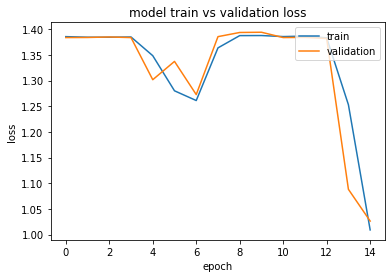

In [0]:
from matplotlib import pyplot
pyplot.plot(historyb.history['loss'])
pyplot.plot(historyb.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [0]:
modelb.evaluate(
  np.array(test_data4),
  to_categorical(np.array(test_label4)))

2566/2566 [==============================] - 4s 2ms/step


[1.0364806576808356, 0.4828526973724365]

**LSTM**(😡🙂) **Word2Vec Embedding**

In [0]:
vocab_size=train_embedding_weights_W3.shape[0]
op_dim=300
lstm=196
output=len(emo)
modelx = Sequential()
e = Embedding(vocab_size, op_dim, input_length=train_data3.shape[1], weights=[train_embedding_weights_W3], trainable=False)
modelx.add(e)
modelx.add(LSTM(lstm, dropout=0.2, recurrent_dropout=0.2))
modelx.add(Dense(output,activation='softmax'))
modelx.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(modelx.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 300)           3154200   
_________________________________________________________________
lstm_3 (LSTM)                (None, 196)               389648    
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 788       
Total params: 3,544,636
Trainable params: 390,436
Non-trainable params: 3,154,200
_________________________________________________________________
None


In [0]:
from keras.utils.np_utils import to_categorical
historyx = modelx.fit(np.array(train_data3),
      to_categorical(np.array(train_label3)), epochs = 15, batch_size=128, verbose = 1, 
          validation_data=(np.array(validate_data3), to_categorical(np.array(validate_label3))))

Train on 7693 samples, validate on 2564 samples
Epoch 1/15
7693/7693 [==============================] - 26s 3ms/step - loss: 1.1405 - accuracy: 0.4548 - val_loss: 0.9476 - val_accuracy: 0.5757
Epoch 2/15
7693/7693 [==============================] - 25s 3ms/step - loss: 0.8667 - accuracy: 0.6116 - val_loss: 0.7660 - val_accuracy: 0.6369
Epoch 3/15
7693/7693 [==============================] - 25s 3ms/step - loss: 0.7854 - accuracy: 0.6577 - val_loss: 0.6666 - val_accuracy: 0.7223
Epoch 4/15
7693/7693 [==============================] - 26s 3ms/step - loss: 0.7059 - accuracy: 0.7385 - val_loss: 0.5828 - val_accuracy: 0.7906
Epoch 5/15
7693/7693 [==============================] - 25s 3ms/step - loss: 0.6130 - accuracy: 0.7864 - val_loss: 0.5866 - val_accuracy: 0.7734
Epoch 6/15
7693/7693 [==============================] - 25s 3ms/step - loss: 0.5756 - accuracy: 0.7908 - val_loss: 0.5381 - val_accuracy: 0.7972
Epoch 7/15
7693/7693 [==============================] - 26s 3ms/step - loss: 0.619

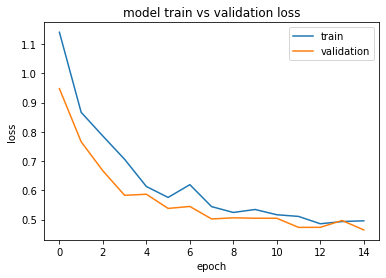

In [0]:
from matplotlib import pyplot
pyplot.plot(historyx.history['loss'])
pyplot.plot(historyx.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [0]:
modelx.evaluate(
  np.array(test_data3),
  to_categorical(np.array(test_label3)))

2565/2565 [==============================] - 4s 2ms/step


[0.4640437183150074, 0.8241715431213379]

**LSTM**(😡🙂) **Keras Embedding**


In [0]:
from keras.layers import Dropout
vocab_size=train_embedding_weights_W3.shape[0]
op_dim=300
lstm=196
output=len(emo)
modelk = Sequential()
modelk.add(Embedding(vocab_size, op_dim ,input_length = train_data3.shape[1]))
modelk.add(LSTM(lstm, dropout=0.2, recurrent_dropout=0.2))
modelk.add(Dense(output,activation='softmax'))
modelk.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(modelk.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 300)           3154200   
_________________________________________________________________
lstm_4 (LSTM)                (None, 196)               389648    
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 788       
Total params: 3,544,636
Trainable params: 3,544,636
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
from keras.utils.np_utils import to_categorical
historyk = modelk.fit(np.array(train_data3),
      to_categorical(np.array(train_label3)), epochs = 15, batch_size=128, verbose = 1, 
          validation_data=(np.array(validate_data3), to_categorical(np.array(validate_label3))))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 7693 samples, validate on 2564 samples
Epoch 1/15
7693/7693 [==============================] - 32s 4ms/step - loss: 1.3835 - accuracy: 0.2784 - val_loss: 1.3691 - val_accuracy: 0.2598
Epoch 2/15
7693/7693 [==============================] - 32s 4ms/step - loss: 1.1670 - accuracy: 0.4431 - val_loss: 1.0183 - val_accuracy: 0.5289
Epoch 3/15
7693/7693 [==============================] - 32s 4ms/step - loss: 0.8217 - accuracy: 0.6648 - val_loss: 0.6247 - val_accuracy: 0.7699
Epoch 4/15
7693/7693 [==============================] - 32s 4ms/step - loss: 0.5302 - accuracy: 0.8244 - val_loss: 0.6535 - val_accuracy: 0.7898
Epoch 5/15
7693/7693 [==============================] - 32s 4ms/step - loss: 0.4062 - accuracy: 0.8640 - val_loss: 0.5248 - val_accuracy: 0.7906
Epoch 6/15
7693/7693 [==============================] - 32s 4ms/step - loss: 0.3261 - accuracy: 0.8959 - val_loss: 0.5760 - val_accuracy: 0.8085
Epoch 7/15
7693/7693 [==============================] - 32s 4ms/step - loss: 0.263

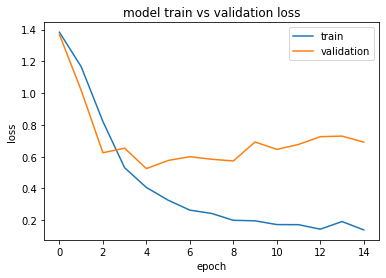

In [0]:
from matplotlib import pyplot
pyplot.plot(historyk.history['loss'])
pyplot.plot(historyk.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [0]:
modelk.evaluate(
  np.array(test_data3),
  to_categorical(np.array(test_label3)))

2565/2565 [==============================] - 4s 2ms/step


[0.7228160362955742, 0.8124756217002869]

**Word2vec+Emoji2vec** ON **LSTM**(😡🙂)

In [0]:
vocab_size=train_embedding_weights1.shape[0]
op_dim=300
lstm=196
output=len(emo)
model2 = Sequential()
e = Embedding(vocab_size, op_dim, input_length=train_data1.shape[1], weights=[train_embedding_weights1], trainable=False)
model2.add(e)
model2.add(LSTM(lstm, dropout=0.2, recurrent_dropout=0.2))
model2.add(Dense(output,activation='softmax'))
model2.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model2.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 300)           3115200   
_________________________________________________________________
lstm_5 (LSTM)                (None, 196)               389648    
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 788       
Total params: 3,505,636
Trainable params: 390,436
Non-trainable params: 3,115,200
_________________________________________________________________
None


In [0]:
from keras.utils.np_utils import to_categorical
history2 = model2.fit(np.array(train_data1),
      to_categorical(np.array(train_label1)), epochs = 15, batch_size=128, verbose = 1, 
          validation_data=(np.array(validate_data1), to_categorical(np.array(validate_label1))))

Train on 7693 samples, validate on 2564 samples
Epoch 1/15
7693/7693 [==============================] - 25s 3ms/step - loss: 1.2342 - accuracy: 0.3992 - val_loss: 1.0860 - val_accuracy: 0.5304
Epoch 2/15
7693/7693 [==============================] - 25s 3ms/step - loss: 1.0622 - accuracy: 0.5228 - val_loss: 0.9197 - val_accuracy: 0.6170
Epoch 3/15
7693/7693 [==============================] - 25s 3ms/step - loss: 0.9620 - accuracy: 0.6103 - val_loss: 0.8356 - val_accuracy: 0.6677
Epoch 4/15
7693/7693 [==============================] - 25s 3ms/step - loss: 0.8561 - accuracy: 0.6779 - val_loss: 0.7508 - val_accuracy: 0.7317
Epoch 5/15
7693/7693 [==============================] - 26s 3ms/step - loss: 0.8611 - accuracy: 0.6780 - val_loss: 0.7902 - val_accuracy: 0.7040
Epoch 6/15
7693/7693 [==============================] - 25s 3ms/step - loss: 0.7463 - accuracy: 0.7378 - val_loss: 0.6642 - val_accuracy: 0.7746
Epoch 7/15
7693/7693 [==============================] - 25s 3ms/step - loss: 0.720

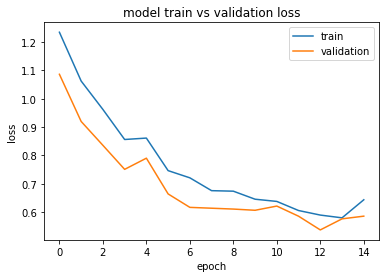

In [0]:
from matplotlib import pyplot
pyplot.plot(history2.history['loss'])
pyplot.plot(history2.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [0]:
model2.evaluate(
  np.array(test_data1),
  to_categorical(np.array(test_label1)))

2566/2566 [==============================] - 4s 2ms/step


[0.5835792916135126, 0.794622004032135]

**Word2vec+Emoji2vec** on **CNN**(😡🙂)

In [0]:
def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=False)
    
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    convs = []
    filter_sizes = [2,3,4,5,6]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=200, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)


    l_merge = concatenate(convs, axis=1)

    x = Dropout(0.1)(l_merge)  
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    preds = Dense(labels_index, activation='sigmoid')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    model.summary()
    return model

In [0]:
label_names = ['anger', 'joy', 'neutral', 'sadness']
from keras.utils.np_utils import to_categorical
vocab_size = train_embedding_weights1.shape[0]
model3 = ConvNet(train_embedding_weights1, train_data1.shape[1], vocab_size, 300, 
                len(list(label_names)))


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 50, 300)      3115200     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 49, 200)      120200      embedding_6[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 48, 200)      180200      embedding_6[0][0]                
____________________________________________________________________________________________

In [0]:
history3 = model3.fit(np.array(train_data1),
      to_categorical(np.array(train_label1)), epochs = 15, batch_size=128, verbose = 1, 
          validation_data=(np.array(validate_data1), to_categorical(np.array(validate_label1))))

Train on 7693 samples, validate on 2564 samples
Epoch 1/15
7693/7693 [==============================] - 37s 5ms/step - loss: 0.8988 - acc: 0.6316 - val_loss: 0.5360 - val_acc: 0.8085
Epoch 2/15
7693/7693 [==============================] - 37s 5ms/step - loss: 0.4126 - acc: 0.8530 - val_loss: 0.4930 - val_acc: 0.8183
Epoch 3/15
7693/7693 [==============================] - 37s 5ms/step - loss: 0.2344 - acc: 0.9266 - val_loss: 0.5087 - val_acc: 0.8233
Epoch 4/15
7693/7693 [==============================] - 37s 5ms/step - loss: 0.1300 - acc: 0.9630 - val_loss: 0.5039 - val_acc: 0.8319
Epoch 5/15
7693/7693 [==============================] - 36s 5ms/step - loss: 0.0811 - acc: 0.9817 - val_loss: 0.5356 - val_acc: 0.8315
Epoch 6/15
7693/7693 [==============================] - 37s 5ms/step - loss: 0.0555 - acc: 0.9852 - val_loss: 0.5617 - val_acc: 0.8358
Epoch 7/15
7693/7693 [==============================] - 38s 5ms/step - loss: 0.0413 - acc: 0.9912 - val_loss: 0.6105 - val_acc: 0.8272
Epoch 8

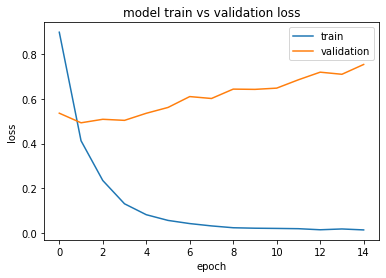

In [0]:
from matplotlib import pyplot
pyplot.plot(history3.history['loss'])
pyplot.plot(history3.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [0]:
model3.evaluate(
  np.array(test_data1),
  to_categorical(np.array(test_label1)))

2566/2566 [==============================] - 5s 2ms/step


[0.781629113705476, 0.8273577690124512]